In [ ]:
!pip install ranx

In [ ]:
!wget -O trec-pm.tar.xz https://th-koeln.sciebo.de/s/JTTV4fxFmuCGMeY/download
!tar -xf trec-pm.tar.xz

In [ ]:
!wget -O bibliometric.tar.xz https://th-koeln.sciebo.de/s/BRolGxMzrCipoTT/download
!tar -xf bibliometric.tar.xz

In [ ]:
import os
import gzip

def extract_runs(dir_in, dir_out):

    os.makedirs(dir_out, exist_ok=True)

    for root, dirs, files in os.walk(dir_in):
        for file in files:
            if file.endswith(".gz"):
                run_name = file.split('.')[1]
                with gzip.open(os.path.join(root, file), 'rb') as f_in:
                    file_content = f_in.read()
                    with open(dir_out + '/' + run_name, 'wb') as f_out:
                        f_out.write(file_content) 
                          
DIR_IN = 'trec-pm/trec-pm-2017-abstracts' 
DIR_OUT = 'runs/trec-pm-2017-abstracts'    
                    
extract_runs(DIR_IN, DIR_OUT)

In [2]:
from ranx import Qrels, Run, evaluate, compare
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

k = 60

def rrf_init(run):
    _run = Run()
    for qid, ranking in dict(run).items():  
        for docid, score in ranking.items():
            doclist = list(ranking.keys())
            rrf_score = 1 / (k + doclist.index(docid))
            _run.add_score(str(qid), str(docid), rrf_score)
            
    return _run

def rrf_add(run_ref, run_add):
    run_fuse = Run()
    
    for qid, ranking_ref in dict(run_ref).items():
        ranking_add = dict(run_add).get(qid)
        for docid, score in ranking_ref.items():
            doclist = list(ranking_add.keys())
            rrf_score = score
            if docid in doclist:
                rrf_score += 1 / (k + doclist.index(docid))
            run_fuse.add_score(str(qid), str(docid), rrf_score)
            
    return run_fuse

def rrf(run_ref, runs):
    
    run_ref = rrf_init(run_ref)

    for run in runs:
        run_ref = rrf_add(run_ref, run) 
    
    return run_ref

def get_run(category):
    
    _run = Run()

    df = pd.read_csv('STI_Ergebnisse_final.txt', sep='\t')

    _df = df[df[category].notna()]
    _df = _df[_df['TOPIC'].str.contains('2017', regex=False)]
    _df = _df[['TOPIC','PUBMED_ID', category]]

    for row in _df.iterrows():
        topic = row[1]['TOPIC'].split('-')[1]
        pubmed_id = row[1]['PUBMED_ID']
        citation_cnt = row[1][category]

        if citation_cnt > 0:
            _run.add_score(str(topic), str(pubmed_id), float(citation_cnt))
    
    return _run

In [4]:
DIR_RUN = 'runs/trec-pm-2017-abstracts/'
PATH_QRELS = "trec-pm/trec-pm-2017-abstracts/qrels-final-abstracts.txt"
qrels = Qrels.from_file(PATH_QRELS, kind="trec")

run_cite = get_run('TC') # get run based on citations
run_alt = get_run('ATTENTION_SCORE')

df_data = []

for root, dirs, files in os.walk(DIR_RUN):
    for file in files:
        run = Run.from_file(os.path.join(root, file), kind="trec")
        run_rrf = rrf(run, [run_cite, run_alt])
        
        ndcg_base = evaluate(qrels, run, "ndcg")
        ndcg_rrf = evaluate(qrels, run_rrf, "ndcg")
        ndcg_diff = ndcg_rrf - ndcg_base
        
        p_10_base = evaluate(qrels, run, "precision@10")
        p_10_rrf = evaluate(qrels, run_rrf, "precision@10")
        p_10_diff = p_10_rrf - p_10_base
        
        map_base = evaluate(qrels, run, "map")
        map_rrf = evaluate(qrels, run_rrf, "map")
        map_diff = map_rrf - map_base
        
        print(file, '\nnDCG (delta):', str(ndcg_diff), '\nAP (delta):', str(map_diff), '\nP@10 (delta):', str(p_10_diff))
        
             
        df_data.append({'System': file, 
                        'nDCG (base)': ndcg_base, 
                        'nDCG (rrf)': ndcg_rrf,
                        'nDCG (delta)': ndcg_diff,
                        'AP (base)': map_base, 
                        'AP (rrf)': map_rrf,
                        'AP (delta)': map_diff,
                        'P@10 (base)': p_10_base, 
                        'P@10 (rrf)': p_10_rrf,
                        'P@10 (delta)': p_10_diff}) 
 
df = pd.DataFrame(df_data)
df.to_csv('experimental_results/rrf.csv')

/home/breuert/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (2,5,7,8,9,10,12,13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


UDInfoPMSA3 
nDCG (delta): -0.0033370460407129987 
AP (delta): 0.029488251429086565 
P@10 (delta): -0.0666666666666666
ielabRun3 
nDCG (delta): 0.020532323756905217 
AP (delta): 0.006192534849433644 
P@10 (delta): 0.07333333333333335
ECNU_M_5 
nDCG (delta): 0.008080365206088347 
AP (delta): 0.03800305415661348 
P@10 (delta): -0.026666666666666672
aCSIROmedMGB 
nDCG (delta): 0.0508524826548315 
AP (delta): 0.04967097774770196 
P@10 (delta): 0.0833333333333334
mayonlppm2 
nDCG (delta): 0.016024180574402525 
AP (delta): 0.0346370033110185 
P@10 (delta): -0.08333333333333326
mayonlppm1 
nDCG (delta): -0.015228253932603686 
AP (delta): 0.007409209187570376 
P@10 (delta): -0.06999999999999995
SDSFU_Jnal 
nDCG (delta): 0.03645879091848264 
AP (delta): 0.05084594553931343 
P@10 (delta): 0.046666666666666634
Textual 
nDCG (delta): 0.00258374938663547 
AP (delta): 0.03803926580990982 
P@10 (delta): -0.0033333333333332993
KISTI02 
nDCG (delta): 0.00401049932053732 
AP (delta): 0.03549389293776169

<AxesSubplot:xlabel='System'>

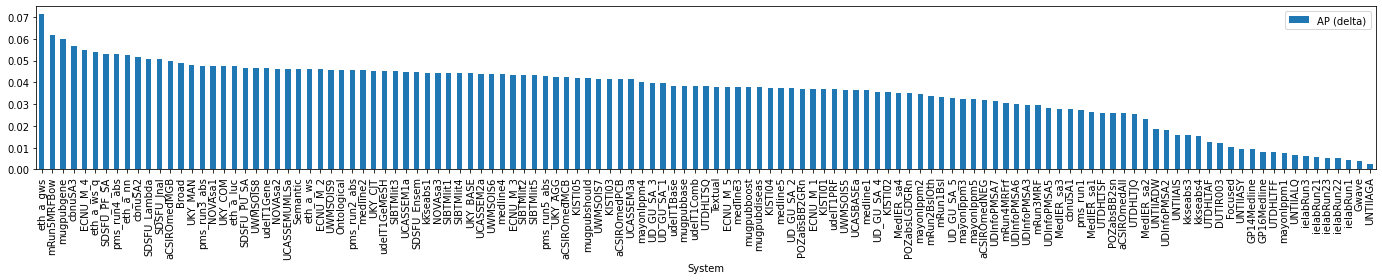

In [12]:
df = pd.read_csv('experimental_results/rrf.csv')
df.sort_values(by=['AP (delta)'], ascending=False).plot.bar(x='System', y='AP (delta)', figsize=(24,3))

<AxesSubplot:xlabel='System'>

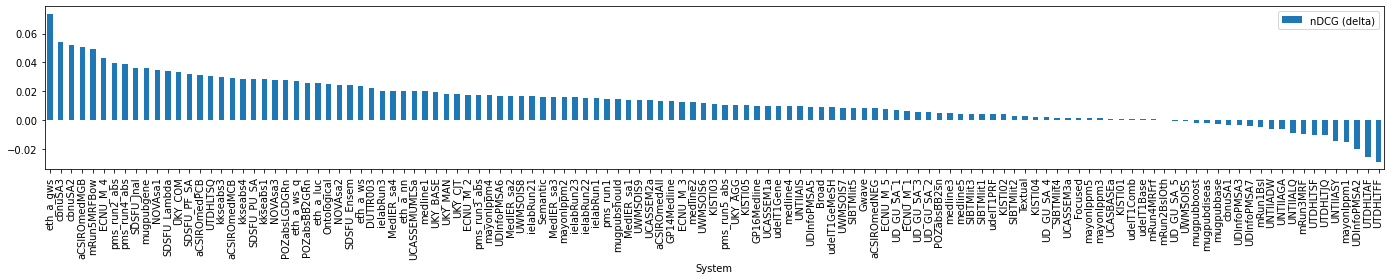

In [13]:
df.sort_values(by=['nDCG (delta)'], ascending=False).plot.bar(x='System', y='nDCG (delta)', figsize=(24,3))

<AxesSubplot:xlabel='System'>

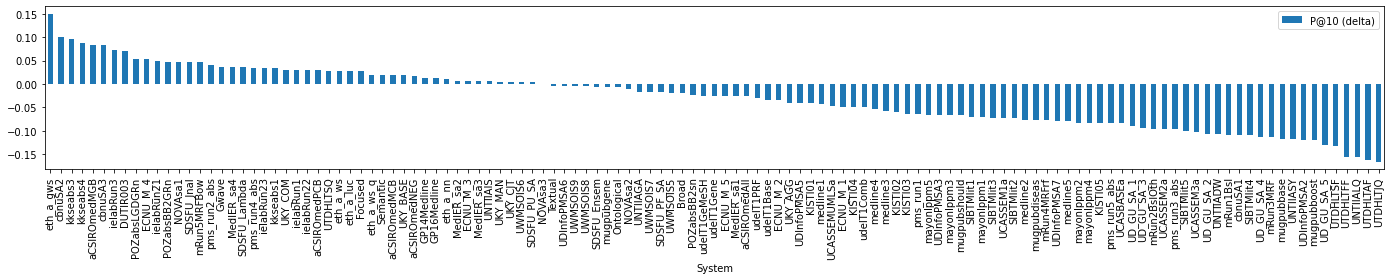

In [14]:
df.sort_values(by=['P@10 (delta)'], ascending=False).plot.bar(x='System', y='P@10 (delta)', figsize=(24,3))